In [1]:
#hide
from utils import *
hc(
    "A Tutorial on Hidden Markov Models and Selected Applications in Speech Recognition",
    [""]
)
toc(
    [
        "References",
        "Goal",
        "Observable Markov Model",
        "An OMM Example"
        "Hidden Markov Model"
    ],
    1
)

## References

1. [1966: Statistical Inference for Probabilistic Functions of Finite State Markov Chains](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-37/issue-6/Statistical-Inference-for-Probabilistic-Functions-of-Finite-State-Markov-Chains/10.1214/aoms/1177699147.full)
3. [1989: A Tutorial on HMM by Rabiner](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=18626) (Main)
4. [2012: Chapter 17 Machine Learning - A Probabilistic Perspective](https://raw.githubusercontent.com/kerasking/book-1/master/ML%20Machine%20Learning-A%20Probabilistic%20Perspective.pdf)
5. [A Revealing Introduction to Hidden Markov Models](https://www.cs.sjsu.edu/~stamp/RUA/HMM.pdf)

## Goal

1. To follow [2] thoroughly.
2. To understand HMM from mathematical perspective.
3. To be able to implement HMM from scratch in Python
4. To be able to use it in a real-world context.

## Observable Markov Model

Consider a system that is charaterized at any given time $t \in \{0, 1, 2, \dots \}$ by a state variable $q_t \in \mathbb{S} = \{S_0, S_1, \dots, S_{N-1}\}$.

The probability of the system to be in state $S_j$ at time $t$ (depends only on its past) is defined as \
$P[q_t = S_j | q_{t-1} = S_i, q_{t-2} = S_k, \dots]$

To simplify the problem, we make few assumptions:

1. The system's current state $q_t$ only depends on it's immediate previous state $q_{t-1}$. \
$P[q_t = S_j | q_{t-1} = S_i, q_{t-2} = S_k, \dots] = P[q_t = S_j | q_{t-1} = S_i]$
2. The dependency is independent of $t$. \
$P[q_t = S_j | q_{t-1} = S_i] = a_{ij}$ \
where, $a_{ij}$ is independent of $t$ meaning $\frac{da_{ij}}{dt} = 0$
3. The system at any $t$ has to be in one of the states $\mathbb{S}$. \
$a_{ij} \ge 0$ and $\sum_{j=0}^{N-1}a_{ij} = 1$

JARGON
- ${a_{ij}}$ is the probability of $S_i \rightarrow S_j$ transition and is often referred to as *State Transition Probabilites.*
- The system that follows the above assumptions are called *N-state Observable Markov Models (N-state OMMs)*. The reason for calling it as *observable* is due to the states i.e. elements $\in \mathbb{S}$ being physical observables.

## An OMM Example

Suppose the weather for a day can be characterized into one the three states. Hence the system can be modelled with a *3-State Observable Markov Model*.
- State 0 ($S_0$): rain/snow
- State 1 ($S_1$): cloudy
- State 2 ($S_2$): sunny

with the following state transition probabilites written in matrix form

$A = {a_{ij}} = \begin{bmatrix} 0.4 & 0.3 & 0.3 \\ 0.2 & 0.6 & 0.2 \\ 0.1 & 0.1 & 0.8 \end{bmatrix}$

We also define $\pi_{i}$ which is the probability of initialising the system with state $i$,

$\pi_{i} = P(q_1 = S_i), \quad 0 \le i \le 2$

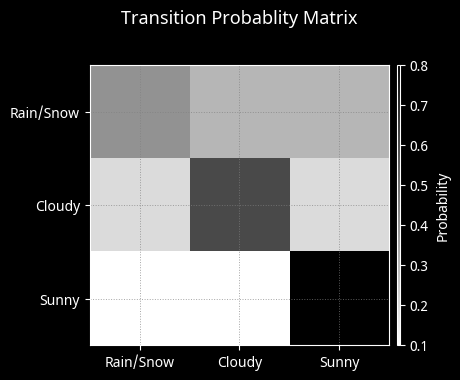

In [2]:
#hide
import numpy as np
import modusa as ms

A = np.array([[0.4, 0.3, 0.3], [0.2, 0.6, 0.2], [0.1, 0.1, 0.8]])
fig = ms.fig("m", width=4)
fig.add_matrix(A, label="Probability", 
               yticks=[0, 1, 2], yticklabels=["Rain/Snow", "Cloudy", "Sunny"], 
               xticks=[0, 1, 2], xticklabels=["Rain/Snow", "Cloudy", "Sunny"],
              )
fig.add_title("Transition Probablity Matrix")

For any OMMs, we are interested in the following queries:
- The probability of observing a given sequence of states.
- Given the model is in state $S_i$, the probability of the model to stays in the same state $S_i$ for next $d$ duration.

The probability of getting a given sequence of observations $O$ say, $O = \{S_2, S_2, S_2, S_0, S_0, S_2, S_1, S_2\}$ corresponding to $t = \{0, 1, 2, ..., 7\}$ is given by:

$P(O|\text{Model}) = P(S_2, S_2, S_2, S_0, S_0, S_2, S_1, S_2|\text{Model})$

$= P(S_2) \times P(S_2 | S_2) \times P(S_2 | S_2) \times P(S_0 | S_2) \times P(S_0 | S_0) \times P(S_2 | S_0) \times P(S_1 | S_2) \times P(S_2 | S_1)$

$= \pi_{2} \times a_{22} \times a_{22} \times a_{20} \times a_{00} \times a_{02} \times a_{21} \times a_{12}$


In [3]:
def compute_prob_obsv(O, A, pi):
    """
    Compute probability of occurence of
    a series of observations O given the
    OMM characterized by A.

    Parameters
    ----------
    O: list[index]
        - Observation sequences i.e. sequence of states to find the probability of.
    A: ndarray
        - Transition probabilities.
    pi: ndarray
        - Initial probabilities.
    """
    curr_state = O[0]
    P = pi[curr_state] # Initial probability
    for i in range(1, len(O)):
        prev_state = O[i-1]
        curr_state = O[i]
        P *= A[prev_state, curr_state]

    return P

P = compute_prob_obsv([2, 2, 2, 0, 0, 2, 1, 2], A, pi=[1, 1, 1])
print(f"{P:.3e}")

1.536e-04


The probability of the system staying in the same state for $d$ duration is given by:

$P(O|\text{Model})$ where, $O = \{S_i, S_i, ..., S_i, S_j \ne S_i \}$ for $t = \{0, 1, ..., d-1, d \}$

$P(O|\text{Model}, q_0 = S_i) = (a_{ii})^{d-1} \times (1 - a_{ii}) = p_i(d)$

JARGON \
$p_i(d)$ is known as (discrete) probability density function (PDF) of duration $d$ in state $i$

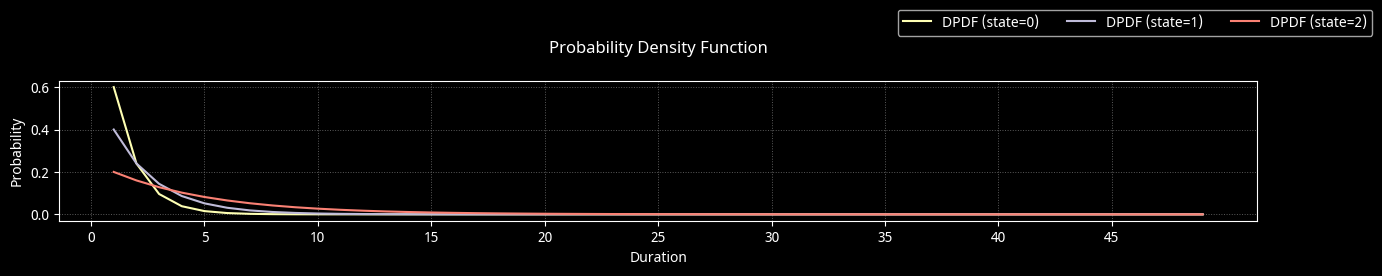

In [9]:
def compute_dpdf(s0, d, A):
    """
    Compute the discrete probability
    density function of duration d in
    state i.

    s0: int
        - Starting state of the system that needs to be retained for next d duration.
    d: int
        - For how many duration (>0), the state should be unchanged from s0.
    A: ndarray
        - Transition probability of the system.

    Returns
    -------
    float
        - Computed probability.
    """
    
    aii = A[s0, s0]

    if d <= 0:
        raise ValueError("d must be greater than 0")

    return (aii ** (d - 1)) * (1 - aii)

D = 50 # Total duration for the state to remain unchanged
dpdf0 = np.zeros(D-1)
dpdf1 = np.zeros(D-1)
dpdf2 = np.zeros(D-1)
ds = np.zeros(D-1)

for d in range(1, 50):
    dpdf0[d-1] = compute_dpdf(0, d, A)
    dpdf1[d-1] = compute_dpdf(1, d, A)
    dpdf2[d-1] = compute_dpdf(2, d, A)
    ds[d-1] = d

fig = ms.fig("s")
fig.add_signal(dpdf0, ds, label=f"DPDF (state={0})", ylabel="Probability", ax=1, xticks=np.arange(0, 50, 5))
fig.add_signal(dpdf1, ds, label=f"DPDF (state={1})", ylabel="Probability", ax=1)
fig.add_signal(dpdf2, ds, label=f"DPDF (state={2})", ylabel="Probability", ax=1)
fig.add_title("Probability Density Function", s=12)
fig.add_xlabel("Duration")
fig.add_legend(1.2)

To find the expected number of observations (duration) in a state us given by:

$\bar d_{i} = \sum_{d=1}^{\infty} d p_i(d)$

$ = \sum_{d=1}^{\infty} d (a_{ii})^{d-1} \times (1 - a_{ii})$

$ = (1 - a_{ii}) \sum_{d=1}^{\infty} d (a_{ii})^{d-1}$

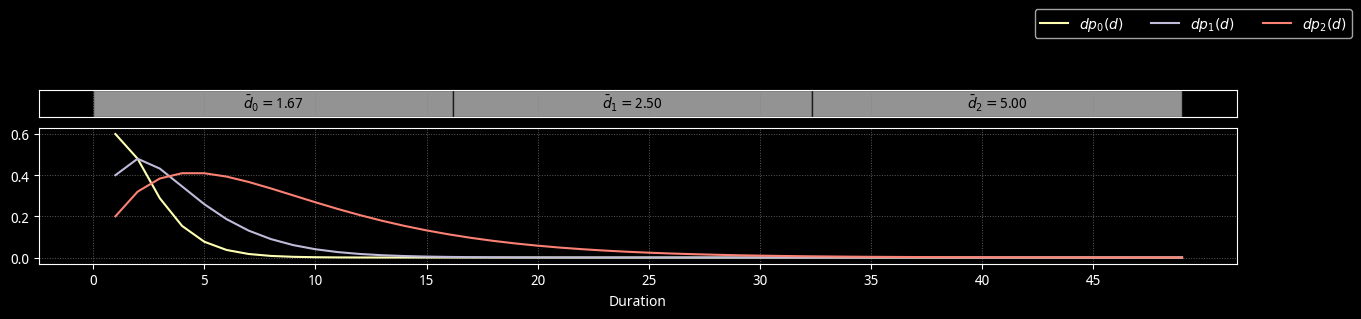

In [13]:
def compute_expected_d(pd, d):
    """
    Compute expected number of consecutive
    days to stay in a state i.
    """
    return np.sum(d*pd)

exp_d_s0 = compute_expected_d(dpdf0, ds) # Expected d for state 0
exp_d_s1 = compute_expected_d(dpdf1, ds) # Expected d for state 1
exp_d_s2 = compute_expected_d(dpdf2, ds) # Expected d for state 2

fig = ms.fig("as")
fig.add_annotation([(0 * ds[-1], 0.33 * ds[-1], f"$\\bar d_0 = ${exp_d_s0:.2f}"), (0.33 * ds[-1], 0.66 * ds[-1], f"$\\bar d_1 = ${exp_d_s1:.2f}"), (0.66 * ds[-1], 1.0 * ds[-1], f"$\\bar d_2 = ${exp_d_s2:.2f}")])
fig.add_signal(ds*dpdf0, ds, label=f"$dp_{0}(d)$", ax=2, xticks=np.arange(0, 50, 5))
fig.add_signal(ds*dpdf1, ds, label=f"$dp_{1}(d)$", ax=2)
fig.add_signal(ds*dpdf2, ds, label=f"$dp_{2}(d)$", ax=2)

fig.add_xlabel("Duration")
fig.add_legend(1.2)

The area under the curve gives us $\bar d_i$. The computed values are mentioned above the plot which matches the values mentioned in the paper.

## Hidden Markov Model

So far we discussed about systems where the state $\in \mathbb{S}$ corresponds to a physical observable event. We extend this idea to include case where the state that we observe is not exactly the observable event that we are interested in. 

Think of it as two layers, layer-1 with states that we can observe but are not of our interest directly and layer-2 with states that we can't observe but are interested in getting a measurement of.

In [46]:
np.sum((ds**2)*(dpdf2))

np.float64(44.94762000967771)

In [12]:
np.sum(dpdf2)

np.float64(0.9999821594038412)

In [66]:
np.sum(dpdf0 * ds)

np.float64(1.6666666666666665)

In [67]:
np.sum(dpdf1 * ds)

np.float64(2.4999999993062247)

In [68]:
np.sum(dpdf2 * ds)

np.float64(4.999036607807425)